## Import Statements and Setting Seeds

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import Module,CrossEntropyLoss,ModuleList
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as fp
import math
from time import time
from tqdm import tqdm

import os

In [2]:
np.random.seed = 42
torch.manual_seed(42)

## Read Light Curves

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Change this path to where your light curves are
path = 'drive/MyDrive/MASS_Astro_Info/LSST_AGN_DC/'

In [5]:
#Loading all the generated files
all_light_curves = np.load(path+'light_curves.npy')
all_time_instances = np.load(path+'time_instances.npy')
all_labels = np.load(path+'labels.npy')

In [6]:
#Loading those with 1fA tiktoks and no tiktoks only
No_Af1_light_curves = np.load(path+'light_curves_no_Af1.npy')
No_Af1_time_instances = np.load(path+'time_instances_no_Af1.npy')
No_Af1_labels = np.load(path+'labels_no_Af1.npy')

In [7]:
#Loading those with 1fA tiktoks and no tiktoks only
No_1fA_light_curves = np.load(path+'light_curves_no_1fA.npy')
No_1fA_time_instances = np.load(path+'time_instances_no_1fA.npy')
No_1fA_labels = np.load(path+'labels_no_1fA.npy')

In [8]:
#50/50 ratio tiktok and non-ticktock
light_curves_5050 = np.load(path+'light_curves_5050.npy')
time_instances_5050 = np.load(path+'time_instances_5050.npy')
labels_5050 = np.load(path+'labels_5050.npy')

In [9]:
#70/30 ratio tiktok and non-ticktock
light_curves_7030 = np.load(path+'light_curves_7030.npy')
time_instances_7030 = np.load(path+'time_instances_7030.npy')
labels_7030 = np.load(path+'labels_7030.npy')

In [10]:
chosen_set = 'less_tiktok' #Chose from all, no_af1, no_1fa, 5050

In [11]:
if chosen_set == 'all':
  light_curves = all_light_curves;time_instances = all_time_instances;labels = all_labels
elif chosen_set == 'no_af1':
  light_curves = No_Af1_light_curves;time_instances = No_Af1_time_instances;labels = No_Af1_labels
elif chosen_set == 'no_1fa':
  light_curves = No_1fA_light_curves;time_instances = No_1fA_time_instances;labels = No_1fA_labels
elif chosen_set == '5050':
  light_curves = light_curves_5050;time_instances = time_instances_5050;labels = labels_5050
elif chosen_set == 'less_tiktok':
  light_curves = light_curves_7030;time_instances = time_instances_7030;labels = labels_7030

In [12]:
modified_time_instances = []
for i in tqdm(range(len(time_instances))):
  modified_time_instances.append(time_instances[i] - time_instances[i][0])
modified_time_instances = np.array(modified_time_instances)

100%|██████████| 429/429 [00:00<00:00, 145555.45it/s]


100%|██████████| 429/429 [00:01<00:00, 379.12it/s]


Text(0, 0.5, 'Mean Magnitude')

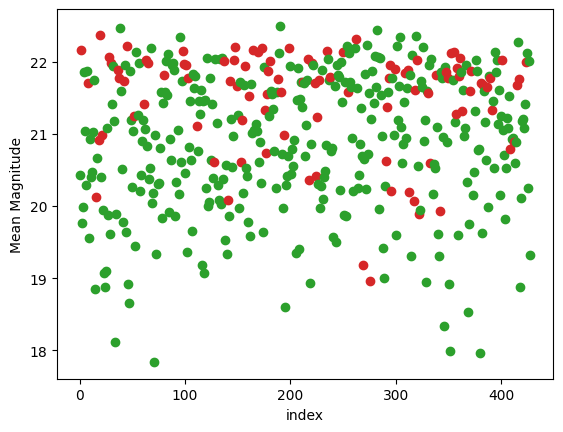

In [13]:
#Checking if there's clear seperation of the means
for i in tqdm(range(len(light_curves))):
  if labels[i] == 0:
    color = 'tab:green'
  elif labels[i] == 1:
    color = 'tab:red'
  plt.scatter(i,np.mean(light_curves[i]),color = color)
plt.xlabel('index')
plt.ylabel('Mean Magnitude')

In [14]:
label_dict = {0: 'No-tt', 1:'tt'}

## Normalize Light Curves

In [15]:
# Normalizing the light curve data
mean = light_curves.mean(axis=0)
std = light_curves.std(axis=0)
light_curves = (light_curves - mean) / std

## Train Test Split

In [16]:
num_curves = len(labels)

In [17]:
#Concatenating times and fluxes
times_and_fluxes_list = []
use_modified_times = True #Whether to use subtracted times
for i in range(len(light_curves)):
  if use_modified_times:
    times_and_fluxes_list.append(np.concatenate((modified_time_instances[i].reshape(len(light_curves[i]),1),light_curves[i].reshape(len(light_curves[i]),1)),axis = 1))
  else:
    times_and_fluxes_list.append(np.concatenate((time_instances[i].reshape(len(light_curves[i]),1),light_curves[i].reshape(len(light_curves[i]),1)),axis = 1))
times_and_fluxes = np.array(times_and_fluxes_list)

In [18]:
train_size = int(0.8 * num_curves)
val_size = test_size = (num_curves - train_size) // 2

# Splitting the data
X_train, X_val, X_test = times_and_fluxes[:train_size], times_and_fluxes[train_size:train_size+val_size], times_and_fluxes[train_size+val_size:]
y_train, y_val, y_test = labels[:train_size], labels[train_size:train_size+val_size], labels[train_size+val_size:]

In [19]:
class LightCurveDataset(Dataset):
    def __init__(self, times_and_fluxes, labels):
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.inputs = torch.tensor(times_and_fluxes, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [20]:
batch_size = 16

# Creating datasets
train_dataset = LightCurveDataset(X_train, y_train)
val_dataset = LightCurveDataset(X_val, y_val)
test_dataset = LightCurveDataset(X_test, y_test)

# Creating dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Transfomer Architecture

In [21]:
#MultiHead Attention Class
class MultiHeadAttention(Module):
    def __init__(self,
                 d_model: int,
                 q: int,
                 v: int,
                 h: int,
                 device: str,
                 mask: bool=False,
                 dropout: float = 0.1):
        super(MultiHeadAttention, self).__init__()
        self.W_q = torch.nn.Linear(d_model, q * h)
        self.W_k = torch.nn.Linear(d_model, q * h)
        self.W_v = torch.nn.Linear(d_model, v * h)

        self.W_o = torch.nn.Linear(v * h, d_model)

        self.device = device
        self._h = h
        self._q = q

        self.mask = mask
        self.dropout = torch.nn.Dropout(p=dropout)
        self.score = None

    def forward(self, x, stage):
        Q = torch.cat(self.W_q(x).chunk(self._h, dim=-1), dim=0)
        K = torch.cat(self.W_k(x).chunk(self._h, dim=-1), dim=0)
        V = torch.cat(self.W_v(x).chunk(self._h, dim=-1), dim=0)

        score = torch.matmul(Q, K.transpose(-1, -2)) / math.sqrt(self._q)
        self.score = score

        if self.mask and stage == 'train':
            mask = torch.ones_like(score[0])
            mask = torch.tril(mask, diagonal=0)
            score = torch.where(mask > 0, score, torch.Tensor([-2**32+1]).expand_as(score[0]).to(self.device))

        score = F.softmax(score, dim=-1)

        attention = torch.matmul(score, V)

        attention_heads = torch.cat(attention.chunk(self._h, dim=0), dim=-1)

        self_attention = self.W_o(attention_heads)

        return self_attention, self.score

In [22]:
#This is just a fancy way to get the CrossEntropyLoss
class Myloss(Module):
    def __init__(self):
        super(Myloss, self).__init__()
        self.loss_function = CrossEntropyLoss()

    def forward(self, y_pre, y_true):
        y_true = y_true.long()
        loss = self.loss_function(y_pre, y_true)

        return loss

In [23]:
#Fancy way to FeedForward
class FeedForward(Module):
    def __init__(self,
                 d_model: int,
                 d_hidden: int = 512):
        super(FeedForward, self).__init__()

        self.linear_1 = torch.nn.Linear(d_model, d_hidden)
        self.linear_2 = torch.nn.Linear(d_hidden, d_model)

    def forward(self, x):

        x = self.linear_1(x)
        x = F.relu(x)
        x = self.linear_2(x)

        return x

In [24]:
#Creating the Encoder
class Encoder(Module):
    def __init__(self,
                 d_model: int,
                 d_hidden: int,
                 q: int,
                 v: int,
                 h: int,
                 device: str,
                 mask: bool = False,
                 dropout: float = 0.1):
        super(Encoder, self).__init__()

        self.MHA = MultiHeadAttention(d_model=d_model, q=q, v=v, h=h, mask=mask, device=device, dropout=dropout)
        self.feedforward = FeedForward(d_model=d_model, d_hidden=d_hidden)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.layerNormal_1 = torch.nn.LayerNorm(d_model)
        self.layerNormal_2 = torch.nn.LayerNorm(d_model)

    def forward(self, x, stage):

        residual = x
        x, score = self.MHA(x, stage)
        x = self.dropout(x)
        x = self.layerNormal_1(x + residual)

        residual = x
        x = self.feedforward(x)
        x = self.dropout(x)
        x = self.layerNormal_2(x + residual)

        return x, score

In [25]:
#Final Transformer Model
class Transformer(Module):
    def __init__(self,
                 d_model: int,
                 d_input: int,
                 d_channel: int,
                 d_output: int,
                 d_hidden: int,
                 q: int,
                 v: int,
                 h: int,
                 N: int,
                 device: str,
                 dropout: float = 0.1,
                 pe: bool = False,
                 mask: bool = False):
        super(Transformer, self).__init__()

        self.encoder_list_1 = ModuleList([Encoder(d_model=d_model,
                                                  d_hidden=d_hidden,
                                                  q=q,
                                                  v=v,
                                                  h=h,
                                                  mask=mask,
                                                  dropout=dropout,
                                                  device=device) for _ in range(N)])

        self.encoder_list_2 = ModuleList([Encoder(d_model=d_model,
                                                  d_hidden=d_hidden,
                                                  q=q,
                                                  v=v,
                                                  h=h,
                                                  dropout=dropout,
                                                  device=device) for _ in range(N)])

        self.embedding_channel = torch.nn.Linear(d_channel, d_model)
        self.embedding_input = torch.nn.Linear(d_input, d_model)

        self.gate = torch.nn.Linear(d_model * d_input + d_model * d_channel, 2)
        self.output_linear = torch.nn.Linear(d_model * d_input + d_model * d_channel, d_output)

        self.pe = pe
        self._d_input = d_input
        self._d_model = d_model

    def forward(self, x, stage):
        """
        前向传播
        :param x: 输入
        :param stage: 用于描述此时是训练集的训练过程还是测试集的测试过程  测试过程中均不在加mask机制
        :return: 输出，gate之后的二维向量，step-wise encoder中的score矩阵，channel-wise encoder中的score矩阵，step-wise embedding后的三维矩阵，channel-wise embedding后的三维矩阵，gate
        """
        # step-wise
        # score矩阵为 input， 默认加mask 和 pe
        encoding_1 = self.embedding_channel(x)
        input_to_gather = encoding_1

        if self.pe:
            pe = torch.ones_like(encoding_1[0])
            position = torch.arange(0, self._d_input).unsqueeze(-1)
            temp = torch.Tensor(range(0, self._d_model, 2))
            temp = temp * -(math.log(10000) / self._d_model)
            temp = torch.exp(temp).unsqueeze(0)
            temp = torch.matmul(position.float(), temp)  # shape:[input, d_model/2]
            pe[:, 0::2] = torch.sin(temp)
            pe[:, 1::2] = torch.cos(temp)

            encoding_1 = encoding_1 + pe

        for encoder in self.encoder_list_1:
            encoding_1, score_input = encoder(encoding_1, stage)

        # channel-wise
        # score矩阵为channel 默认不加mask和pe
        encoding_2 = self.embedding_input(x.transpose(-1, -2))
        channel_to_gather = encoding_2

        for encoder in self.encoder_list_2:
            encoding_2, score_channel = encoder(encoding_2, stage)

        # 三维变二维
        encoding_1 = encoding_1.reshape(encoding_1.shape[0], -1)
        encoding_2 = encoding_2.reshape(encoding_2.shape[0], -1)

        # gate
        gate = F.softmax(self.gate(torch.cat([encoding_1, encoding_2], dim=-1)), dim=-1)
        encoding = torch.cat([encoding_1 * gate[:, 0:1], encoding_2 * gate[:, 1:2]], dim=-1)

        # 输出
        output = self.output_linear(encoding)

        return output, encoding, score_input, score_channel, input_to_gather, channel_to_gather, gate

## Defining Parameters

In [26]:
EPOCH = 150 #Number of epochs
BATCH_SIZE = batch_size #Batch Size
LR = 1e-4 #Learning Rate (If too high, takes the obvious solution of calling everything a ticktock. If too low, gets stuck in a local\
          #minima and overfits (test loss goes down but validation loss gets really high))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # CPU or GPU
print(f'use device: {DEVICE}')

use device: cuda:0


In [27]:
d_model = 64 #Model Dimensions
d_hidden = 1024 #Dimension of Hidden Layers
q = 8 #queries
v = 8 #Values
h = 8 #Number of heads
N = 8 #Need to figure it out
dropout = 0.2 #Dropout Rate
pe = True   # Whether you want positional encoding
mask = True  # Whether you want masking (Recommended)
optimizer_name = 'Adam'

In [28]:
DATA_LEN = len(train_dataset)
d_input = len(train_dataset[0][0])  # This is the length of the time series
d_channel = len(train_dataset[0][0][0])  #This is how many inputs there are (Don't include the labels)
d_output = len(np.unique(train_dataset[:][:][1])) #There's 0 and 1 as the classes

In [29]:
#Initialize the transformer with the above values
net = Transformer(d_model=d_model, d_input=d_input, d_channel=d_channel, d_output=d_output, d_hidden=d_hidden,
                  q=q, v=v, h=h, N=N, dropout=dropout, pe=pe, mask=mask, device=DEVICE).to(DEVICE)

#Adam is usually the best but if you really want, change it to Adagrad above
loss_function = Myloss()
if optimizer_name == 'Adagrad':
    optimizer = optim.Adagrad(net.parameters(), lr=LR)
elif optimizer_name == 'Adam':
    optimizer = optim.Adam(net.parameters(), lr=LR)

# Functions for Test and Train

In [30]:
#Test function
def test(dataloader, model,flag='test_set',confusion_matrix_plot = False,verbose = True):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        predictions = np.array([])
        truths = np.array([])
        running_loss = 0.0
        for x, y in dataloader:
            optimizer.zero_grad()
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pre, _, _, _, _, _, _ = model(x, 'test')
            loss = loss_function(y_pre, y.to(DEVICE))
            running_loss += loss
            _, label_index = torch.max(y_pre.data, dim=-1)
            predictions = np.concatenate((predictions,label_index.cpu().data.numpy()))
            truths = np.concatenate((truths,y.cpu().data.numpy()))
            total += label_index.shape[0]
            correct += (label_index == y.long()).sum().item()
        if verbose:
          print(f'Accuracy on {flag}: %.2f %%' % (100 * correct / total))
        if confusion_matrix_plot:
          cf_matrix = confusion_matrix(truths,predictions)
          df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in label_dict.keys()],
                      columns = [i for i in label_dict.keys()])
          df_cm.columns = ['Actual_Non_TT','Actual_TT']
          df_cm.index = ['Predicted_Non_TT','Predicted_TT']
          plt.figure(figsize = (12,7))
          sns.heatmap(df_cm, annot=True)
        return running_loss.cpu().data.numpy()/len(dataloader),correct/total


In [31]:
# Train function
def train(model,train_loader = train_loader,validation_loader = val_loader,epochs = EPOCH,include_validation = True):
    model.train()
    epoch_losses = []
    val_losses = []
    val_accuracies = []
    best_val_acc = 0.0
    best_val_loss = 1.0
    for index in tqdm(range(epochs),desc = 'Epochs'):
        running_loss = 0.0
        for i,(x,y) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pre, enc, _, _, _, _, _ = model(x.to(DEVICE), 'train')
            loss = loss_function(y_pre, y.to(DEVICE))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        #Getting the loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_losses.append(epoch_loss)
        #Checking with validation data
        if include_validation:
          val_loss, val_acc = test(val_loader, model, flag = 'test_set',confusion_matrix_plot=False,verbose = False)
          val_losses.append(val_loss)
          val_accuracies.append(val_acc)
          if val_acc >= best_val_acc and val_loss < best_val_loss:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        #Final print
        print(f'Epoch {index+1}, Train Loss: {epoch_loss:.4f},Val Loss: {val_loss},Val Acc: {val_acc}')
    return model,epoch_losses,val_losses,val_accuracies


# Train your model

In [32]:
#Training the model
best_net,epoch_losses,val_losses,val_accuracies = train(net,train_loader,val_loader,EPOCH)

Epochs:   1%|          | 1/150 [00:01<04:50,  1.95s/it]

Epoch 1, Train Loss: 0.5891,Val Loss: 0.5862823724746704,Val Acc: 0.6976744186046512


Epochs:   1%|▏         | 2/150 [00:02<03:22,  1.37s/it]

Epoch 2, Train Loss: 0.4912,Val Loss: 0.5206315517425537,Val Acc: 0.813953488372093


Epochs:   2%|▏         | 3/150 [00:03<02:52,  1.17s/it]

Epoch 3, Train Loss: 0.4309,Val Loss: 0.6167811155319214,Val Acc: 0.7209302325581395


Epochs:   3%|▎         | 4/150 [00:04<02:39,  1.09s/it]

Epoch 4, Train Loss: 0.4131,Val Loss: 0.4020195007324219,Val Acc: 0.8604651162790697


Epochs:   3%|▎         | 5/150 [00:05<02:31,  1.04s/it]

Epoch 5, Train Loss: 0.3636,Val Loss: 0.392927090326945,Val Acc: 0.8604651162790697


Epochs:   4%|▍         | 6/150 [00:06<02:25,  1.01s/it]

Epoch 6, Train Loss: 0.3314,Val Loss: 0.4128464063008626,Val Acc: 0.8604651162790697


Epochs:   5%|▍         | 7/150 [00:07<02:30,  1.05s/it]

Epoch 7, Train Loss: 0.3661,Val Loss: 0.4771929184595744,Val Acc: 0.7674418604651163


Epochs:   5%|▌         | 8/150 [00:09<02:40,  1.13s/it]

Epoch 8, Train Loss: 0.3954,Val Loss: 0.5233811537424723,Val Acc: 0.7674418604651163


Epochs:   6%|▌         | 9/150 [00:10<02:49,  1.20s/it]

Epoch 9, Train Loss: 0.4568,Val Loss: 0.31323206424713135,Val Acc: 0.9302325581395349


Epochs:   7%|▋         | 10/150 [00:11<02:50,  1.22s/it]

Epoch 10, Train Loss: 0.3525,Val Loss: 0.25688137610753375,Val Acc: 0.9302325581395349


Epochs:   7%|▋         | 11/150 [00:12<02:38,  1.14s/it]

Epoch 11, Train Loss: 0.3630,Val Loss: 0.24414050579071045,Val Acc: 0.9302325581395349


Epochs:   8%|▊         | 12/150 [00:13<02:29,  1.08s/it]

Epoch 12, Train Loss: 0.5721,Val Loss: 0.4738634427388509,Val Acc: 0.7441860465116279


Epochs:   9%|▊         | 13/150 [00:14<02:23,  1.04s/it]

Epoch 13, Train Loss: 0.5065,Val Loss: 0.4673132499059041,Val Acc: 0.6976744186046512


Epochs:   9%|▉         | 14/150 [00:15<02:18,  1.02s/it]

Epoch 14, Train Loss: 0.4641,Val Loss: 0.4614812135696411,Val Acc: 0.6976744186046512


Epochs:  10%|█         | 15/150 [00:16<02:14,  1.01it/s]

Epoch 15, Train Loss: 0.4588,Val Loss: 0.45148269335428876,Val Acc: 0.6976744186046512


Epochs:  11%|█         | 16/150 [00:17<02:11,  1.02it/s]

Epoch 16, Train Loss: 0.4528,Val Loss: 0.4647212028503418,Val Acc: 0.6976744186046512


Epochs:  11%|█▏        | 17/150 [00:18<02:08,  1.04it/s]

Epoch 17, Train Loss: 0.4455,Val Loss: 0.4662558635075887,Val Acc: 0.6976744186046512


Epochs:  12%|█▏        | 18/150 [00:19<02:06,  1.04it/s]

Epoch 18, Train Loss: 0.4500,Val Loss: 0.4550308386484782,Val Acc: 0.6976744186046512


Epochs:  13%|█▎        | 19/150 [00:20<02:03,  1.06it/s]

Epoch 19, Train Loss: 0.4512,Val Loss: 0.4511967897415161,Val Acc: 0.6976744186046512


Epochs:  13%|█▎        | 20/150 [00:21<02:01,  1.07it/s]

Epoch 20, Train Loss: 0.4350,Val Loss: 0.4363800684611003,Val Acc: 0.6976744186046512


Epochs:  14%|█▍        | 21/150 [00:22<02:09,  1.01s/it]

Epoch 21, Train Loss: 0.4275,Val Loss: 0.42077072461446124,Val Acc: 0.6976744186046512


Epochs:  15%|█▍        | 22/150 [00:23<02:18,  1.08s/it]

Epoch 22, Train Loss: 0.3782,Val Loss: 0.4197406768798828,Val Acc: 0.813953488372093


Epochs:  15%|█▌        | 23/150 [00:24<02:23,  1.13s/it]

Epoch 23, Train Loss: 0.4720,Val Loss: 0.6810660362243652,Val Acc: 0.6976744186046512


Epochs:  16%|█▌        | 24/150 [00:26<02:23,  1.14s/it]

Epoch 24, Train Loss: 0.5425,Val Loss: 0.5939979553222656,Val Acc: 0.6976744186046512


Epochs:  17%|█▋        | 25/150 [00:26<02:14,  1.08s/it]

Epoch 25, Train Loss: 0.5017,Val Loss: 0.5724993944168091,Val Acc: 0.6976744186046512


Epochs:  17%|█▋        | 26/150 [00:27<02:08,  1.03s/it]

Epoch 26, Train Loss: 0.4978,Val Loss: 0.5477267106374105,Val Acc: 0.6976744186046512


Epochs:  18%|█▊        | 27/150 [00:29<02:11,  1.07s/it]

Epoch 27, Train Loss: 0.4324,Val Loss: 0.3779364426930745,Val Acc: 0.8604651162790697


Epochs:  19%|█▊        | 28/150 [00:29<02:06,  1.03s/it]

Epoch 28, Train Loss: 0.3564,Val Loss: 0.4502935806910197,Val Acc: 0.8604651162790697


Epochs:  19%|█▉        | 29/150 [00:30<02:01,  1.00s/it]

Epoch 29, Train Loss: 0.3831,Val Loss: 0.3483903408050537,Val Acc: 0.8604651162790697


Epochs:  20%|██        | 30/150 [00:31<01:58,  1.02it/s]

Epoch 30, Train Loss: 0.3524,Val Loss: 0.3372766574223836,Val Acc: 0.8604651162790697


Epochs:  21%|██        | 31/150 [00:32<01:55,  1.03it/s]

Epoch 31, Train Loss: 0.3655,Val Loss: 0.4173174301783244,Val Acc: 0.7674418604651163


Epochs:  21%|██▏       | 32/150 [00:33<01:52,  1.05it/s]

Epoch 32, Train Loss: 0.4018,Val Loss: 0.3827107747395833,Val Acc: 0.7674418604651163


Epochs:  22%|██▏       | 33/150 [00:34<01:49,  1.06it/s]

Epoch 33, Train Loss: 0.3742,Val Loss: 0.4170495669047038,Val Acc: 0.7441860465116279


Epochs:  23%|██▎       | 34/150 [00:35<01:48,  1.07it/s]

Epoch 34, Train Loss: 0.3977,Val Loss: 0.4060521920522054,Val Acc: 0.7441860465116279


Epochs:  23%|██▎       | 35/150 [00:36<01:57,  1.02s/it]

Epoch 35, Train Loss: 0.3788,Val Loss: 0.3988229036331177,Val Acc: 0.7441860465116279


Epochs:  24%|██▍       | 36/150 [00:38<02:04,  1.10s/it]

Epoch 36, Train Loss: 0.3490,Val Loss: 0.39785850048065186,Val Acc: 0.7674418604651163


Epochs:  25%|██▍       | 37/150 [00:39<02:10,  1.15s/it]

Epoch 37, Train Loss: 0.3630,Val Loss: 0.2306540608406067,Val Acc: 0.8837209302325582


Epochs:  25%|██▌       | 38/150 [00:40<02:09,  1.15s/it]

Epoch 38, Train Loss: 0.3247,Val Loss: 0.5687177975972494,Val Acc: 0.7209302325581395


Epochs:  26%|██▌       | 39/150 [00:41<02:00,  1.08s/it]

Epoch 39, Train Loss: 0.4695,Val Loss: 0.417658011118571,Val Acc: 0.7906976744186046


Epochs:  27%|██▋       | 40/150 [00:42<01:54,  1.04s/it]

Epoch 40, Train Loss: 0.3894,Val Loss: 0.42718831698099774,Val Acc: 0.6976744186046512


Epochs:  27%|██▋       | 41/150 [00:43<01:50,  1.01s/it]

Epoch 41, Train Loss: 0.3773,Val Loss: 0.426003098487854,Val Acc: 0.6976744186046512


Epochs:  28%|██▊       | 42/150 [00:44<01:47,  1.01it/s]

Epoch 42, Train Loss: 0.3784,Val Loss: 0.4105157454808553,Val Acc: 0.6976744186046512


Epochs:  29%|██▊       | 43/150 [00:45<01:45,  1.02it/s]

Epoch 43, Train Loss: 0.3949,Val Loss: 0.4048087199529012,Val Acc: 0.6976744186046512


Epochs:  29%|██▉       | 44/150 [00:46<01:43,  1.03it/s]

Epoch 44, Train Loss: 0.3542,Val Loss: 0.35263411204020184,Val Acc: 0.8604651162790697


Epochs:  30%|███       | 45/150 [00:47<01:40,  1.04it/s]

Epoch 45, Train Loss: 0.3938,Val Loss: 0.37413203716278076,Val Acc: 0.7209302325581395


Epochs:  31%|███       | 46/150 [00:48<01:39,  1.05it/s]

Epoch 46, Train Loss: 0.3576,Val Loss: 0.5117579301198324,Val Acc: 0.7674418604651163


Epochs:  31%|███▏      | 47/150 [00:48<01:37,  1.05it/s]

Epoch 47, Train Loss: 0.3063,Val Loss: 0.418970266977946,Val Acc: 0.7906976744186046


Epochs:  32%|███▏      | 48/150 [00:49<01:36,  1.06it/s]

Epoch 48, Train Loss: 0.2585,Val Loss: 0.2628085215886434,Val Acc: 0.9302325581395349


Epochs:  33%|███▎      | 49/150 [00:51<01:44,  1.03s/it]

Epoch 49, Train Loss: 0.3236,Val Loss: 0.33334259192148846,Val Acc: 0.8604651162790697


Epochs:  33%|███▎      | 50/150 [00:52<01:52,  1.12s/it]

Epoch 50, Train Loss: 0.2971,Val Loss: 0.24292389551798502,Val Acc: 0.9302325581395349


Epochs:  34%|███▍      | 51/150 [00:53<01:56,  1.18s/it]

Epoch 51, Train Loss: 0.2120,Val Loss: 0.271509051322937,Val Acc: 0.9302325581395349


Epochs:  35%|███▍      | 52/150 [00:54<01:54,  1.16s/it]

Epoch 52, Train Loss: 0.1798,Val Loss: 0.2551124294598897,Val Acc: 0.9302325581395349


Epochs:  35%|███▌      | 53/150 [00:55<01:47,  1.11s/it]

Epoch 53, Train Loss: 0.1962,Val Loss: 0.23374950885772705,Val Acc: 0.9302325581395349


Epochs:  36%|███▌      | 54/150 [00:56<01:42,  1.07s/it]

Epoch 54, Train Loss: 0.1663,Val Loss: 0.23546443382898966,Val Acc: 0.9302325581395349


Epochs:  37%|███▋      | 55/150 [00:57<01:38,  1.04s/it]

Epoch 55, Train Loss: 0.1739,Val Loss: 0.2135691444079081,Val Acc: 0.9302325581395349


Epochs:  37%|███▋      | 56/150 [00:58<01:35,  1.01s/it]

Epoch 56, Train Loss: 0.1768,Val Loss: 0.2063945730527242,Val Acc: 0.9302325581395349


Epochs:  38%|███▊      | 57/150 [00:59<01:31,  1.01it/s]

Epoch 57, Train Loss: 0.2483,Val Loss: 0.49806944529215497,Val Acc: 0.8372093023255814


Epochs:  39%|███▊      | 58/150 [01:00<01:29,  1.03it/s]

Epoch 58, Train Loss: 0.2684,Val Loss: 0.47255929311116535,Val Acc: 0.813953488372093


Epochs:  39%|███▉      | 59/150 [01:01<01:26,  1.05it/s]

Epoch 59, Train Loss: 0.2403,Val Loss: 0.3385617733001709,Val Acc: 0.8604651162790697


Epochs:  40%|████      | 60/150 [01:02<01:24,  1.06it/s]

Epoch 60, Train Loss: 0.3307,Val Loss: 0.34261858463287354,Val Acc: 0.8837209302325582


Epochs:  41%|████      | 61/150 [01:03<01:23,  1.07it/s]

Epoch 61, Train Loss: 0.3134,Val Loss: 0.3539200226465861,Val Acc: 0.9069767441860465


Epochs:  41%|████▏     | 62/150 [01:04<01:22,  1.07it/s]

Epoch 62, Train Loss: 0.2310,Val Loss: 0.48644991715749103,Val Acc: 0.8837209302325582


Epochs:  42%|████▏     | 63/150 [01:05<01:29,  1.03s/it]

Epoch 63, Train Loss: 0.2416,Val Loss: 0.3677355448404948,Val Acc: 0.8837209302325582


Epochs:  43%|████▎     | 64/150 [01:06<01:35,  1.11s/it]

Epoch 64, Train Loss: 0.2027,Val Loss: 0.3377334276835124,Val Acc: 0.8837209302325582


Epochs:  43%|████▎     | 65/150 [01:08<01:38,  1.16s/it]

Epoch 65, Train Loss: 0.2057,Val Loss: 0.3177872896194458,Val Acc: 0.8837209302325582


Epochs:  44%|████▍     | 66/150 [01:09<01:36,  1.15s/it]

Epoch 66, Train Loss: 0.2151,Val Loss: 0.6175421873728434,Val Acc: 0.7441860465116279


Epochs:  45%|████▍     | 67/150 [01:10<01:30,  1.09s/it]

Epoch 67, Train Loss: 0.2478,Val Loss: 0.2806673248608907,Val Acc: 0.8837209302325582


Epochs:  45%|████▌     | 68/150 [01:11<01:25,  1.05s/it]

Epoch 68, Train Loss: 0.2497,Val Loss: 0.3387539784113566,Val Acc: 0.8604651162790697


Epochs:  46%|████▌     | 69/150 [01:12<01:22,  1.01s/it]

Epoch 69, Train Loss: 0.2921,Val Loss: 0.3071502447128296,Val Acc: 0.8837209302325582


Epochs:  47%|████▋     | 70/150 [01:13<01:18,  1.01it/s]

Epoch 70, Train Loss: 0.2713,Val Loss: 0.525468111038208,Val Acc: 0.8604651162790697


Epochs:  47%|████▋     | 71/150 [01:13<01:16,  1.03it/s]

Epoch 71, Train Loss: 0.3556,Val Loss: 0.561187744140625,Val Acc: 0.7209302325581395


Epochs:  48%|████▊     | 72/150 [01:14<01:14,  1.04it/s]

Epoch 72, Train Loss: 0.3111,Val Loss: 0.3159707387288411,Val Acc: 0.8837209302325582


Epochs:  49%|████▊     | 73/150 [01:15<01:14,  1.04it/s]

Epoch 73, Train Loss: 0.2546,Val Loss: 0.20550171534220377,Val Acc: 0.9069767441860465


Epochs:  49%|████▉     | 74/150 [01:16<01:13,  1.04it/s]

Epoch 74, Train Loss: 0.2570,Val Loss: 0.3574550946553548,Val Acc: 0.9069767441860465


Epochs:  50%|█████     | 75/150 [01:17<01:11,  1.05it/s]

Epoch 75, Train Loss: 0.2341,Val Loss: 0.36150825023651123,Val Acc: 0.9069767441860465


Epochs:  51%|█████     | 76/150 [01:18<01:10,  1.05it/s]

Epoch 76, Train Loss: 0.1379,Val Loss: 0.3867689371109009,Val Acc: 0.8837209302325582


Epochs:  51%|█████▏    | 77/150 [01:19<01:16,  1.05s/it]

Epoch 77, Train Loss: 0.4769,Val Loss: 0.6228290796279907,Val Acc: 0.627906976744186


Epochs:  52%|█████▏    | 78/150 [01:21<01:21,  1.14s/it]

Epoch 78, Train Loss: 0.3991,Val Loss: 0.4024159113566081,Val Acc: 0.8604651162790697


Epochs:  53%|█████▎    | 79/150 [01:22<01:24,  1.19s/it]

Epoch 79, Train Loss: 0.2817,Val Loss: 0.3308400710423787,Val Acc: 0.8604651162790697


Epochs:  53%|█████▎    | 80/150 [01:23<01:20,  1.14s/it]

Epoch 80, Train Loss: 0.4044,Val Loss: 0.47062615553538006,Val Acc: 0.8372093023255814


Epochs:  54%|█████▍    | 81/150 [01:24<01:14,  1.08s/it]

Epoch 81, Train Loss: 0.3429,Val Loss: 0.3851812283198039,Val Acc: 0.8372093023255814


Epochs:  55%|█████▍    | 82/150 [01:25<01:10,  1.04s/it]

Epoch 82, Train Loss: 0.2707,Val Loss: 0.23346189657847086,Val Acc: 0.8604651162790697


Epochs:  55%|█████▌    | 83/150 [01:26<01:07,  1.01s/it]

Epoch 83, Train Loss: 0.3214,Val Loss: 0.6368780930836996,Val Acc: 0.7674418604651163


Epochs:  56%|█████▌    | 84/150 [01:27<01:05,  1.01it/s]

Epoch 84, Train Loss: 0.5759,Val Loss: 0.5099349816640218,Val Acc: 0.8604651162790697


Epochs:  57%|█████▋    | 85/150 [01:28<01:03,  1.03it/s]

Epoch 85, Train Loss: 0.3560,Val Loss: 0.4389125108718872,Val Acc: 0.8604651162790697


Epochs:  57%|█████▋    | 86/150 [01:29<01:01,  1.04it/s]

Epoch 86, Train Loss: 0.3017,Val Loss: 0.42185060183207196,Val Acc: 0.8604651162790697


Epochs:  58%|█████▊    | 87/150 [01:30<01:00,  1.04it/s]

Epoch 87, Train Loss: 0.3051,Val Loss: 0.32332785924275714,Val Acc: 0.8604651162790697


Epochs:  59%|█████▊    | 88/150 [01:31<00:59,  1.05it/s]

Epoch 88, Train Loss: 0.2757,Val Loss: 0.26139076550801593,Val Acc: 0.9069767441860465


Epochs:  59%|█████▉    | 89/150 [01:32<00:58,  1.04it/s]

Epoch 89, Train Loss: 0.2528,Val Loss: 0.399722695350647,Val Acc: 0.8604651162790697


Epochs:  60%|██████    | 90/150 [01:33<00:58,  1.03it/s]

Epoch 90, Train Loss: 0.2921,Val Loss: 0.24773383140563965,Val Acc: 0.8604651162790697


Epochs:  61%|██████    | 91/150 [01:34<01:02,  1.07s/it]

Epoch 91, Train Loss: 0.2641,Val Loss: 0.44274020195007324,Val Acc: 0.8372093023255814


Epochs:  61%|██████▏   | 92/150 [01:35<01:05,  1.13s/it]

Epoch 92, Train Loss: 0.2612,Val Loss: 0.27919040123621625,Val Acc: 0.8372093023255814


Epochs:  62%|██████▏   | 93/150 [01:37<01:07,  1.18s/it]

Epoch 93, Train Loss: 0.2336,Val Loss: 0.21185948451360068,Val Acc: 0.8372093023255814


Epochs:  63%|██████▎   | 94/150 [01:38<01:03,  1.14s/it]

Epoch 94, Train Loss: 0.2358,Val Loss: 0.4204940398534139,Val Acc: 0.8372093023255814


Epochs:  63%|██████▎   | 95/150 [01:38<00:58,  1.07s/it]

Epoch 95, Train Loss: 0.1660,Val Loss: 0.19027902682622275,Val Acc: 0.8604651162790697


Epochs:  64%|██████▍   | 96/150 [01:39<00:55,  1.03s/it]

Epoch 96, Train Loss: 0.1960,Val Loss: 0.3252239425977071,Val Acc: 0.9069767441860465


Epochs:  65%|██████▍   | 97/150 [01:40<00:52,  1.01it/s]

Epoch 97, Train Loss: 0.1636,Val Loss: 0.25163692235946655,Val Acc: 0.9069767441860465


Epochs:  65%|██████▌   | 98/150 [01:41<00:50,  1.02it/s]

Epoch 98, Train Loss: 0.1837,Val Loss: 0.16110662619272867,Val Acc: 0.9069767441860465


Epochs:  66%|██████▌   | 99/150 [01:42<00:49,  1.04it/s]

Epoch 99, Train Loss: 0.1829,Val Loss: 0.15287387371063232,Val Acc: 0.9069767441860465


Epochs:  67%|██████▋   | 100/150 [01:43<00:47,  1.05it/s]

Epoch 100, Train Loss: 0.2344,Val Loss: 0.3051549394925435,Val Acc: 0.8837209302325582


Epochs:  67%|██████▋   | 101/150 [01:44<00:46,  1.06it/s]

Epoch 101, Train Loss: 0.1912,Val Loss: 0.3413563172022502,Val Acc: 0.8837209302325582


Epochs:  68%|██████▊   | 102/150 [01:45<00:51,  1.08s/it]

Epoch 102, Train Loss: 0.2260,Val Loss: 0.34765275319417316,Val Acc: 0.8837209302325582


Epochs:  69%|██████▊   | 103/150 [01:46<00:49,  1.06s/it]

Epoch 103, Train Loss: 0.1779,Val Loss: 0.2975653608640035,Val Acc: 0.9069767441860465


Epochs:  69%|██████▉   | 104/150 [01:48<00:50,  1.10s/it]

Epoch 104, Train Loss: 0.1443,Val Loss: 0.2307236591974894,Val Acc: 0.9069767441860465


Epochs:  70%|███████   | 105/150 [01:49<00:51,  1.15s/it]

Epoch 105, Train Loss: 0.1306,Val Loss: 0.2581780155499776,Val Acc: 0.8604651162790697


Epochs:  71%|███████   | 106/150 [01:50<00:52,  1.19s/it]

Epoch 106, Train Loss: 0.1307,Val Loss: 0.21201489369074503,Val Acc: 0.9069767441860465


Epochs:  71%|███████▏  | 107/150 [01:51<00:51,  1.19s/it]

Epoch 107, Train Loss: 0.1530,Val Loss: 0.1857247749964396,Val Acc: 0.8837209302325582


Epochs:  72%|███████▏  | 108/150 [01:52<00:46,  1.11s/it]

Epoch 108, Train Loss: 0.1452,Val Loss: 0.3112422227859497,Val Acc: 0.9069767441860465


Epochs:  73%|███████▎  | 109/150 [01:53<00:43,  1.05s/it]

Epoch 109, Train Loss: 0.1382,Val Loss: 0.23018250862757364,Val Acc: 0.9069767441860465


Epochs:  73%|███████▎  | 110/150 [01:54<00:40,  1.01s/it]

Epoch 110, Train Loss: 0.0947,Val Loss: 0.2607429226239522,Val Acc: 0.9069767441860465


Epochs:  74%|███████▍  | 111/150 [01:55<00:38,  1.01it/s]

Epoch 111, Train Loss: 0.1402,Val Loss: 0.2778405745824178,Val Acc: 0.9069767441860465


Epochs:  75%|███████▍  | 112/150 [01:56<00:36,  1.03it/s]

Epoch 112, Train Loss: 0.1185,Val Loss: 0.18536722660064697,Val Acc: 0.9069767441860465


Epochs:  75%|███████▌  | 113/150 [01:57<00:35,  1.03it/s]

Epoch 113, Train Loss: 0.1160,Val Loss: 0.1649201214313507,Val Acc: 0.9069767441860465


Epochs:  76%|███████▌  | 114/150 [01:58<00:34,  1.05it/s]

Epoch 114, Train Loss: 0.0889,Val Loss: 0.302357296148936,Val Acc: 0.9069767441860465


Epochs:  77%|███████▋  | 115/150 [01:59<00:33,  1.06it/s]

Epoch 115, Train Loss: 0.1315,Val Loss: 0.20978248119354248,Val Acc: 0.9534883720930233


Epochs:  77%|███████▋  | 116/150 [02:00<00:31,  1.07it/s]

Epoch 116, Train Loss: 0.1325,Val Loss: 0.19210116068522134,Val Acc: 0.8604651162790697


Epochs:  78%|███████▊  | 117/150 [02:01<00:30,  1.07it/s]

Epoch 117, Train Loss: 0.1162,Val Loss: 0.21253657341003418,Val Acc: 0.9069767441860465


Epochs:  79%|███████▊  | 118/150 [02:02<00:32,  1.02s/it]

Epoch 118, Train Loss: 0.3141,Val Loss: 0.35593191782633465,Val Acc: 0.8837209302325582


Epochs:  79%|███████▉  | 119/150 [02:03<00:34,  1.10s/it]

Epoch 119, Train Loss: 0.2076,Val Loss: 0.35777270793914795,Val Acc: 0.8837209302325582


Epochs:  80%|████████  | 120/150 [02:04<00:34,  1.16s/it]

Epoch 120, Train Loss: 0.1088,Val Loss: 0.28775129715601605,Val Acc: 0.9069767441860465


Epochs:  81%|████████  | 121/150 [02:06<00:33,  1.16s/it]

Epoch 121, Train Loss: 0.0783,Val Loss: 0.32302284240722656,Val Acc: 0.9069767441860465


Epochs:  81%|████████▏ | 122/150 [02:07<00:30,  1.09s/it]

Epoch 122, Train Loss: 0.0526,Val Loss: 0.3258756796518962,Val Acc: 0.9302325581395349


Epochs:  82%|████████▏ | 123/150 [02:07<00:28,  1.05s/it]

Epoch 123, Train Loss: 0.0431,Val Loss: 0.3123165766398112,Val Acc: 0.9302325581395349


Epochs:  83%|████████▎ | 124/150 [02:08<00:26,  1.01s/it]

Epoch 124, Train Loss: 0.0686,Val Loss: 0.23712217807769775,Val Acc: 0.9069767441860465


Epochs:  83%|████████▎ | 125/150 [02:09<00:24,  1.01it/s]

Epoch 125, Train Loss: 0.1879,Val Loss: 0.3154912193616231,Val Acc: 0.9302325581395349


Epochs:  84%|████████▍ | 126/150 [02:10<00:23,  1.03it/s]

Epoch 126, Train Loss: 0.1521,Val Loss: 0.2460577885309855,Val Acc: 0.8604651162790697


Epochs:  85%|████████▍ | 127/150 [02:11<00:22,  1.03it/s]

Epoch 127, Train Loss: 0.1234,Val Loss: 0.12720537185668945,Val Acc: 0.9302325581395349


Epochs:  85%|████████▌ | 128/150 [02:12<00:21,  1.02it/s]

Epoch 128, Train Loss: 0.0935,Val Loss: 0.10136079788208008,Val Acc: 0.9534883720930233


Epochs:  86%|████████▌ | 129/150 [02:13<00:20,  1.03it/s]

Epoch 129, Train Loss: 0.1082,Val Loss: 0.10264249642690022,Val Acc: 0.9767441860465116


Epochs:  87%|████████▋ | 130/150 [02:14<00:19,  1.04it/s]

Epoch 130, Train Loss: 0.2211,Val Loss: 0.3310994307200114,Val Acc: 0.8604651162790697


Epochs:  87%|████████▋ | 131/150 [02:15<00:18,  1.05it/s]

Epoch 131, Train Loss: 0.1370,Val Loss: 0.14638249079386392,Val Acc: 0.9767441860465116


Epochs:  88%|████████▊ | 132/150 [02:16<00:18,  1.05s/it]

Epoch 132, Train Loss: 0.0858,Val Loss: 0.10748053590456645,Val Acc: 0.9069767441860465


Epochs:  89%|████████▊ | 133/150 [02:18<00:19,  1.13s/it]

Epoch 133, Train Loss: 0.1412,Val Loss: 0.18001317977905273,Val Acc: 0.9069767441860465


Epochs:  89%|████████▉ | 134/150 [02:19<00:18,  1.17s/it]

Epoch 134, Train Loss: 0.1291,Val Loss: 0.2477216919263204,Val Acc: 0.9534883720930233


Epochs:  90%|█████████ | 135/150 [02:20<00:17,  1.16s/it]

Epoch 135, Train Loss: 0.1978,Val Loss: 0.2903072436650594,Val Acc: 0.7441860465116279


Epochs:  91%|█████████ | 136/150 [02:21<00:15,  1.09s/it]

Epoch 136, Train Loss: 0.1735,Val Loss: 0.18131246169408163,Val Acc: 0.9302325581395349


Epochs:  91%|█████████▏| 137/150 [02:22<00:13,  1.04s/it]

Epoch 137, Train Loss: 0.1338,Val Loss: 0.13439606626828512,Val Acc: 0.9534883720930233


Epochs:  92%|█████████▏| 138/150 [02:23<00:12,  1.02s/it]

Epoch 138, Train Loss: 0.0966,Val Loss: 0.05534917116165161,Val Acc: 0.9767441860465116


Epochs:  93%|█████████▎| 139/150 [02:24<00:10,  1.01it/s]

Epoch 139, Train Loss: 0.1525,Val Loss: 0.1270783543586731,Val Acc: 0.9767441860465116


Epochs:  93%|█████████▎| 140/150 [02:25<00:09,  1.03it/s]

Epoch 140, Train Loss: 0.2176,Val Loss: 0.335982879002889,Val Acc: 0.813953488372093


Epochs:  94%|█████████▍| 141/150 [02:26<00:08,  1.05it/s]

Epoch 141, Train Loss: 0.1866,Val Loss: 0.0875092347462972,Val Acc: 0.9534883720930233


Epochs:  95%|█████████▍| 142/150 [02:27<00:07,  1.06it/s]

Epoch 142, Train Loss: 0.1034,Val Loss: 0.6710197925567627,Val Acc: 0.7674418604651163


Epochs:  95%|█████████▌| 143/150 [02:28<00:06,  1.06it/s]

Epoch 143, Train Loss: 0.1376,Val Loss: 0.0759200503428777,Val Acc: 0.9534883720930233


Epochs:  96%|█████████▌| 144/150 [02:28<00:05,  1.05it/s]

Epoch 144, Train Loss: 0.1180,Val Loss: 0.05571918189525604,Val Acc: 1.0


Epochs:  97%|█████████▋| 145/150 [02:29<00:04,  1.06it/s]

Epoch 145, Train Loss: 0.1276,Val Loss: 0.09348635872205098,Val Acc: 1.0


Epochs:  97%|█████████▋| 146/150 [02:31<00:04,  1.02s/it]

Epoch 146, Train Loss: 0.1125,Val Loss: 0.08864378929138184,Val Acc: 0.9534883720930233


Epochs:  98%|█████████▊| 147/150 [02:32<00:03,  1.09s/it]

Epoch 147, Train Loss: 0.1258,Val Loss: 0.18126755952835083,Val Acc: 0.8604651162790697


Epochs:  99%|█████████▊| 148/150 [02:33<00:02,  1.16s/it]

Epoch 148, Train Loss: 0.1617,Val Loss: 0.08287781476974487,Val Acc: 1.0


Epochs:  99%|█████████▉| 149/150 [02:34<00:01,  1.16s/it]

Epoch 149, Train Loss: 0.1155,Val Loss: 0.09353021780649821,Val Acc: 0.9534883720930233


Epochs: 100%|██████████| 150/150 [02:35<00:00,  1.04s/it]

Epoch 150, Train Loss: 0.0922,Val Loss: 0.08594356973965962,Val Acc: 0.9534883720930233


# Visualize the training

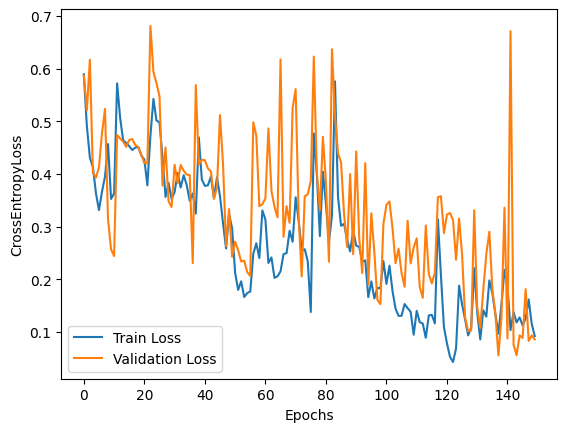

In [33]:
#Plotting the loss
plt.figure()
plt.plot(range(EPOCH),epoch_losses,label = 'Train Loss')
plt.plot(range(EPOCH),val_losses,label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('CrossEntropyLoss')
plt.legend()

Text(0, 0.5, 'Validation Accuracy')

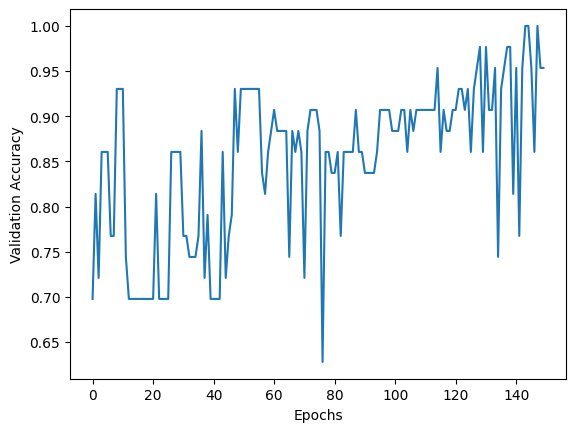

In [34]:
#Plotting the Validation Accuracy
plt.figure()
plt.plot(range(EPOCH),val_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')

# Evaluation

In [322]:
#Loading the best model
net.load_state_dict(torch.load(path+'best_model_TT50_NTT50.pth'))

<All keys matched successfully>

In [35]:
net.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

Accuracy on test_set: 95.35 %


(0.08992035190264384, 0.9534883720930233)

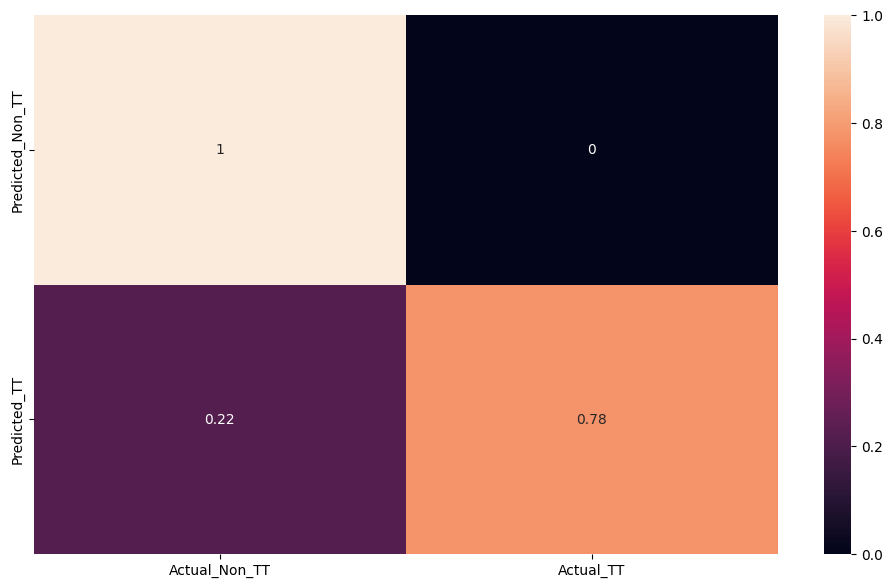

In [36]:
#Plotting the confusion matrix
test(test_loader,net,confusion_matrix_plot=True)

## Checking the Light Curves in the Data Challenge

In [37]:
#Real LSST AGN DC Light Curves
light_curves_dc = np.load(path+'light_curves_dc_pure.npy')
time_instances_dc = np.load(path+'times_dc_pure.npy')
ids_dc = np.load(path+'ids_dc.npy')

In [38]:
#Changing the times
modified_dc_time_instances = []
for i in tqdm(range(len(time_instances_dc))):
  modified_dc_time_instances.append(time_instances_dc[i] - time_instances_dc[i][0])
modified_dc_time_instances = np.array(modified_dc_time_instances)

100%|██████████| 997/997 [00:00<00:00, 143121.40it/s]


In [39]:
#Standardizing the dataset
light_curves_dc = (light_curves_dc-light_curves_dc.mean(axis = 0))/light_curves_dc.std(axis = 0)

In [40]:
#Concatenating times and fluxes
times_and_fluxes_list_dc = []
for i in range(len(light_curves_dc)):
    times_and_fluxes_list_dc.append(np.concatenate((modified_dc_time_instances[i].reshape(len(light_curves_dc[i]),1),light_curves_dc[i].reshape(len(light_curves_dc[i]),1)),axis = 1))
times_and_fluxes_dc = np.array(times_and_fluxes_list_dc)

In [41]:
#If we have longer padding in the full dc, then we should cut a bit off the end so the input dimension of the transformer matches
if len(times_and_fluxes_dc[0]) > d_input:
  chop_off_end = len(times_and_fluxes_dc[0]) - d_input
  new_times_and_fluxes_dc = []
  for i in times_and_fluxes_dc:
    new_times_and_fluxes_dc.append(i[:-chop_off_end])
  new_times_and_fluxes_dc = np.array(new_times_and_fluxes_dc)
  times_and_fluxes_dc = new_times_and_fluxes_dc

In [42]:
times_and_fluxes_dc = torch.tensor(times_and_fluxes_dc, dtype=torch.float32)

In [43]:
#Test function
def test_dc(tensor_times_and_fluxes, model):
  inpur_dimension = len
  with torch.no_grad():
      model.eval()
      predictions = np.array([])
      optimizer.zero_grad()
      tensor_times_and_fluxes = tensor_times_and_fluxes.to(DEVICE)
      y_pre, _, _, _, _, _, _ = model(tensor_times_and_fluxes, 'test')
      _, label_index = torch.max(y_pre.data, dim=-1)
      predictions = np.concatenate((predictions,label_index.cpu().data.numpy()))
      return predictions

In [44]:
is_tik_tok = test_dc(times_and_fluxes_dc,net)

In [45]:
sum(is_tik_tok)

103.0

In [46]:
np.save('Suspected_TikToks.npy',ids_dc[is_tik_tok == 1])